# User's Guide, Chapter 28: Lyric Searching

In [1]:
# ignore this
%load_ext music21.ipython21

Lyrics can be difficult to search through for various reasons.  Let me give an example: you might want to find all instances of, say, the word "Domine" (latin: Lord) to see if, perhaps, they're higher in pitch than the average notes in the piece.  

Let's start by taking a piece that will be a good example, a *Gloria* by the otherwise unknown 15th-century musician, "D. Luca," found in the `music21` corpus.

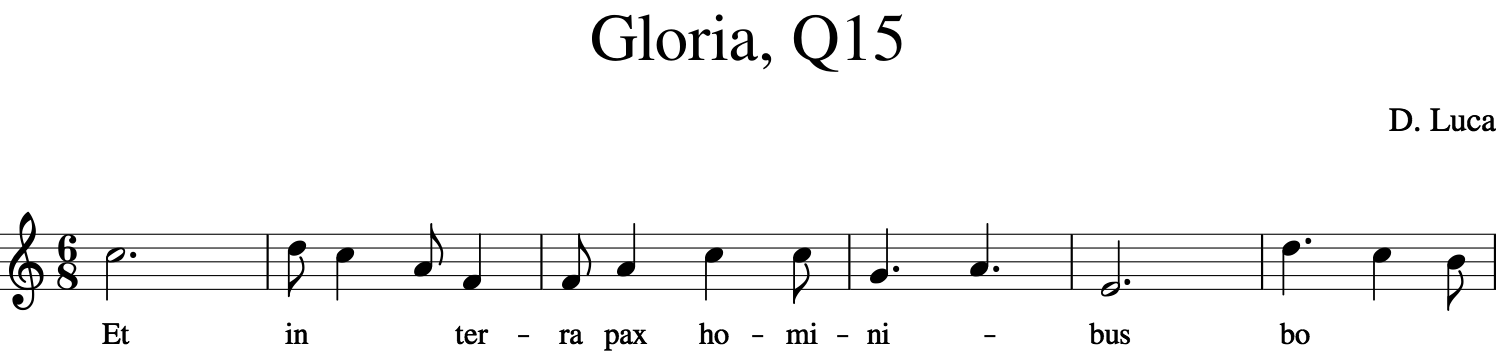

In [2]:
from music21 import *

luca = corpus.parse('luca/gloria')
cantus = luca.parts[0]
cantus.measures(1, 6).show()

This code is unlikely to work:

In [3]:
dominePS = None
for n in cantus.recurse().getElementsByClass('Note'):
    if n.lyric == 'Domine':
        dominePS = n.pitch.ps

Did we get anything?

In [4]:
print(dominePS)

None


Why? Because "domine" is three syllables long.  Thus, it is not going to be found on a single note.  You can check to see if "Domine" appears in the piece at all using the :func:`music21.text.assembleLyrics` function:

In [5]:
allText = text.assembleLyrics(cantus)
if 'Domine' in allText:
    print("Yup!")

Yup!


Well, now we know that the *Gloria* of the Mass, contains the word "Domine". Except we already knew that, and we're no close to figuring out what pitches are used by "Domine".

:class:`music21.search.lyrics.LyricSearcher` will come to your rescue.  We can create a new `LyricSearcher` object and attach the Stream to it:

In [6]:
ls = search.lyrics.LyricSearcher(cantus)

Now let's search for "Domine":

In [7]:
domineResults = ls.search("Domine")

How many times did it appear?

In [8]:
len(domineResults)

3

Three times.  Let's look more closely at the results to see where:

In [9]:
domineResults

[SearchMatch(mStart=28, mEnd=29, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note F>), indices=[...]),
 SearchMatch(mStart=38, mEnd=39, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note B>), indices=[...]),
 SearchMatch(mStart=48, mEnd=48, matchText='Domine', els=(<music21.note.Note A>, <music21.note.Note B>, <music21.note.Note C>), indices=[...])]

We'll get to the meaning of this soon, but we can see that the three matches appear (probably coincidentally) ten measures apart, at measures 28-29, 38-39, and 48.  Let's check that:

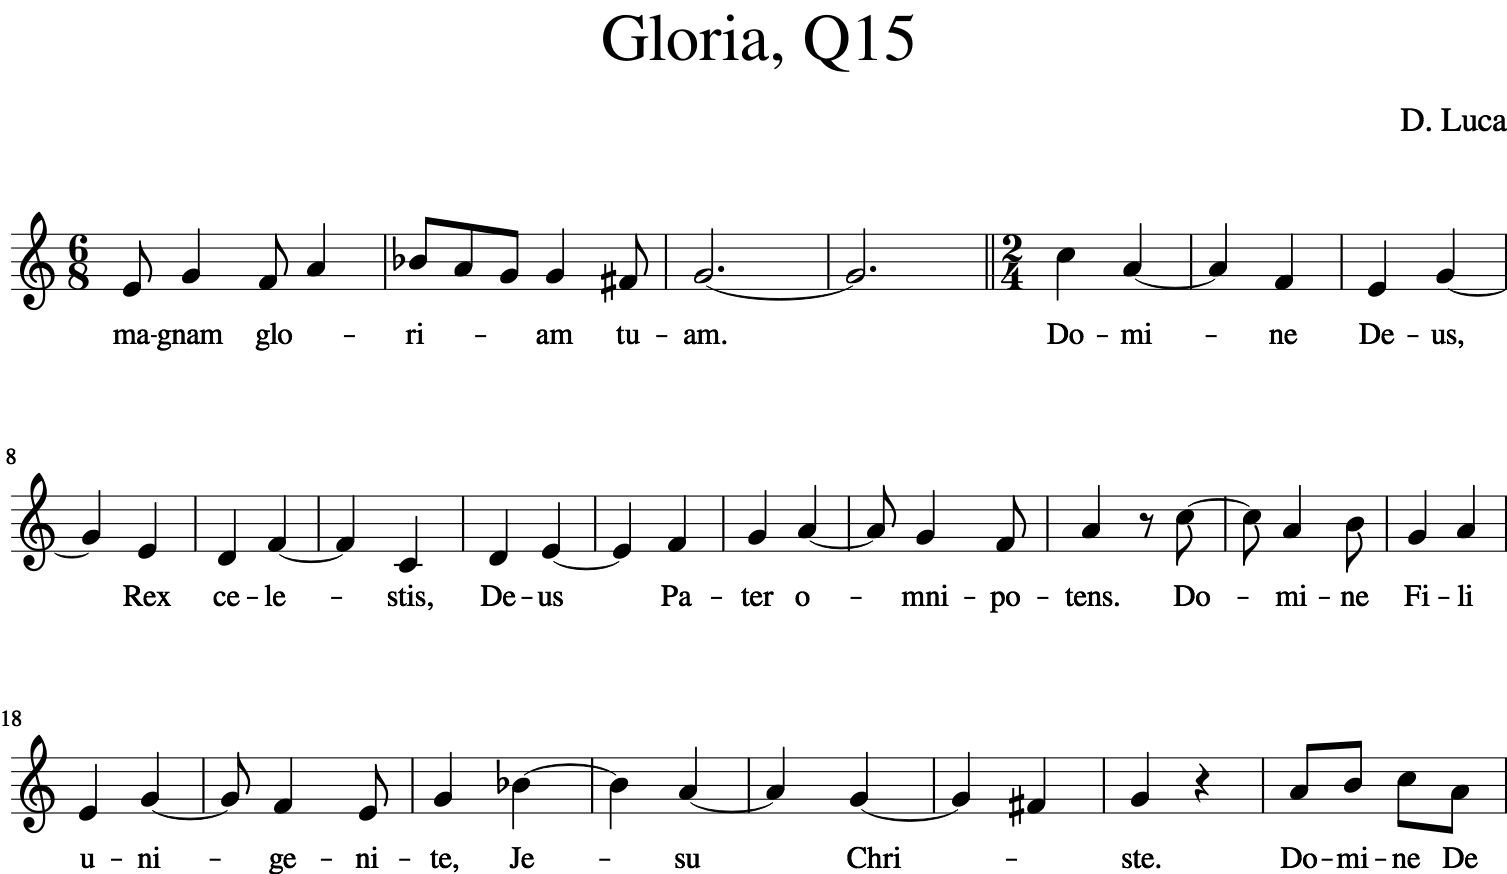

In [10]:
cantus.measures(24, 48).show()

Yep, there they are.  There's something interesting in that all three times the word follows a double-bar or rest.  Clearly it's an important word at an important place in the sentence.  Let's look at the first :class:`~music21.search.lyrics.SearchMatch` object in some detail.  It is a kind of namedtuple that knows something about where the match took place.

In [11]:
sm0 = domineResults[0]
sm0.mStart, sm0.mEnd

(28, 29)

It knows which notes contained the syllables making up "Domine":

In [12]:
sm0.els

(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note F>)

Notice that the second "A" (after the tie) is not included in the search results.  This has nothing to do with the fact that it is tied -- melismas do not include all the notes.  For instance, take "[Glo-]riam tuam." found at the beginning of the excerpt above (measure 25).  There are three notes on "ri" (B-flat, A, G) but only the B-flat will be included in this search:

In [13]:
smGloriam = ls.search('iam tuam.')
smGloriam[0].els

(<music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note F#>,
 <music21.note.Note G>)

Future work should make it possible to return the intermediate notes or rests in between, etc.  For now you could do something like this instead:

In [14]:
firstNote = smGloriam[0].els[0]
lastNote = smGloriam[0].els[-1]

allRelevantNotes = [firstNote]
currentNote = firstNote

while currentNote is not None:
    currentNote = currentNote.next('Note')
    allRelevantNotes.append(currentNote)
    if currentNote is lastNote:
        break

allRelevantNotes

[<music21.note.Note B->,
 <music21.note.Note A>,
 <music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note F#>,
 <music21.note.Note G>]

Okay, that's enough of an aside, let's get back to the Domine pitch question, and what's in a `SearchMatch` object.  It has a `.matchText` attribute.  It tells you what matched:

In [15]:
sm0.matchText

'Domine'

Well, that's pretty useless here.  We knew that.  But what I haven't mentioned is that you can pass in regular expressions.  Let's find the main-stem's vowel combination, o followed by i, with one letter in between:

In [16]:
import re
reSearchVowels = re.compile(r'\w+o\wi\w+', re.IGNORECASE)
foundVowels = ls.search(reSearchVowels)
len(foundVowels)

11

Well, that matched 11 times.  But who knows WHAT it matched?!  Oh, wait, `.matchText` knows.

In [17]:
[result.matchText for result in foundVowels]

['hominibus',
 'Glorificamus',
 'gloriam',
 'Domine',
 'Domine',
 'Domine',
 'nobis',
 'nobis',
 'Quoniam',
 'Dominus',
 'gloria']

The last thing that a `SearchMatch` has is a `.indices` list, which is a list of the :class:`~music21.search.lyrics.IndexedLyric` objects that are the hidden secret-sauce that makes all this work so well.  This is too low-level to need describing here, but look at the docs to the module to see why it might be helpful.

Darn it, we're distracted again from the main problem: is "Domine" higher than average?  Let's get back to that.  `domineResults` is still our list of search results containing "Domine".  We'll look at the average `.ps` or pitch space (MIDI number) for the pitches: 

In [18]:
dominePitchPSes = []
for thisMatch in domineResults:
    for thisNote in thisMatch.els:
        dominePitchPSes.append(thisNote.pitch.ps)

dominePitchPSes

[72.0, 69.0, 65.0, 72.0, 69.0, 71.0, 69.0, 71.0, 72.0]

Python 3.4 and above FINALLY give us a nice set of functions for the mean and median.  This won't work on Python 2, but you can write your own:

In [19]:
from statistics import mean, median

mean(dominePitchPSes), median(dominePitchPSes)

(70.0, 71.0)

And for the piece as a whole?

In [20]:
allPitchPSes = []
for thisNote in cantus.recurse().notes:
    allPitchPSes.append(thisNote.pitch.ps)
    
mean(allPitchPSes), median(allPitchPSes)

(67.41100323624596, 67.0)

It is a little bit higher.  The mean is 2.6 semitones higher and the median is 4 semitones higher.  Is this statistically significant?  We'll need to perform more tests to be sure! (My guess is NOT! but hey, it's worth investigating)

(Btw -- I should have used `.getElementsByClass('Note')` instead of `.notes` for safety above, since `.notes` could also return a `Chord` object, which does not have a `.pitch` object (but rather a `.pitches` list), but I know this piece very well, and I knew it was monophonic.)

Hope that this was a good introduction to searching through lyrics! I've used this technique to find lots of small fragments of music.  I'll write more about that later.  For now, let's move on to ...